# Titanic survival determination
Step by Step Guide:
1. Importing the Libraries
2. Importing the Dataset 
3. Dataset Analysis
    * 3.1 Observing the data
    * 3.2 Removing outliers   
    * 3.3 Determining missing values
    * 3.4 Joining Train/Test Data
4. Visualizing and Comparing Features
    * 4.1 Correlation heatmap 
    * 4.2 Pclass
    * 4.3 Sex
    * 4.4 SibSp
    * 4.5 Parch 
    * 4.6 Embarked
    * 4.7 Cabin    
5. Removing Missing Values
    * 5.1 Age
6. Feature Engineering 
    * 6.1 Title feature
    * 6.2 Family total
    * 6.3 Creating age groups
    * 6.4 Solving fare skewness 
    * 6.5 Mapping categorical sex feature
    * 6.6 Mapping categorical embarked feature
    * 6.7 Removing non-essential features
    * 6.8 Get categorical dummies
7. Building/Training/Evaluating our models
    * 7.1 Seperating Train/Test dataset
    * 7.2 Modelling various classifiers
    * 7.3 Hyperparameter tuning
    * 7.4 Submitting

# 1 - Importing the Libraries

In [1]:
#Importing the data analysis libraries
import numpy as np # linear algebra
import pandas as pd # data processing

#Importing the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Ensuring that we don't see any warnings while running the cells
import warnings
warnings.filterwarnings('ignore') 

#Importing the counter
from collections import Counter

#Importing sci-kit learn libraries that we will need for this project
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# 2 - Importing the Dataset

In [2]:
#Reading the data from the given files and creating a training and test dataset
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

# 3 - Dataset Analysis

## 3.1 Observing the data

In [3]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
129,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
314,315,0,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S
572,573,1,1,"Flynn, Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S
404,405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,NaN,S
571,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C101,S
652,653,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,NaN,S
748,749,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.1000,D30,S
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,330958,7.8792,NaN,Q
687,688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S
396,397,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S


In [4]:
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Kelly, Miss. Mary",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## 3.2 Removing outliers

To remove outliers I used the code from [here](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) as guidance
* We will use 1.5 times the Inter Quartile Range to have close 1% of outliers as compared to 1 times IQR which can give 5% outliers and 2 times IQR which would include most extreme outliers

In [5]:
def detect_outliers(dataframe, n, features):
    
    outliers_indices = []
    
    for feature in features:
        
        #determining the upper and lower quartiles
        Quart1 = dataframe[feature].quantile(0.25)
        Quart3 = dataframe[feature].quantile(0.75)
        
        #determining the upper and lower outlier thresholds to remove the outliers
        upper_outlier_threshold = Quart3 + (Quart3 - Quart1) * 1.5
        lower_outlier_threshold = Quart1 - (Quart3 - Quart1) * 1.5
        
        #finding the outliers and saving their indices in the form of a list, according to the given threshold
        feature_outliers_list = dataframe[(dataframe[feature] > upper_outlier_threshold) | (dataframe[feature] < lower_outlier_threshold)].index
        
        #appending the outliers for each feature to the main outliers_indices list
        outliers_indices.extend(feature_outliers_list)
        
    #Selecting features that have more than 2 outliers
    return list(a for a, b in Counter(outliers_indices).items() if b > n)

In [6]:
outliers = detect_outliers(train, 2, ["Age", "SibSp", "Fare", "Parch"])
train.loc[outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


Observations:
* 3 outliers are due to a very high fare
* 7 Outliers are due to a very high number of SibSp

In [7]:
train = train.drop(outliers, axis = 0).reset_index(drop = True)

## 3.3 Determining the missing values

In [8]:
print(pd.isnull(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64


Observations:
* Only Age(170), Cabin(680) and Embarked(2) have missing values
* The remaining columns have 0 missing values

## 3.4 - Joining Train/Test

First we will combine the train and test data to ensure that we implement the feature engineering on all data, and we don't have discrepancies when modeling and evaluating.
We will split the dataframe again after the feature engineering process.

In [9]:
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
df.describe(include = "all")

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1042.000000,291,1296,1297.000000,1298,1298.000000,1298.000000,1298.000000,1298,1298.000000,880.000000,1298
unique,NaN,186,3,NaN,1296,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,B57 B59 B63 B66,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA 2144
freq,NaN,5,903,NaN,2,NaN,NaN,NaN,837,NaN,NaN,8
mean,29.865326,NaN,NaN,32.539427,NaN,0.372111,657.024653,2.295069,NaN,0.452234,0.386364,NaN
std,14.380828,NaN,NaN,50.702961,NaN,0.857310,377.880768,0.836701,NaN,0.879624,0.487192,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,331.250000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,656.500000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,30.500000,NaN,0.000000,984.750000,3.000000,NaN,1.000000,1.000000,NaN


# 4 - Visualizing and Comparing the Features

## 4.1 - Correlation heatmap

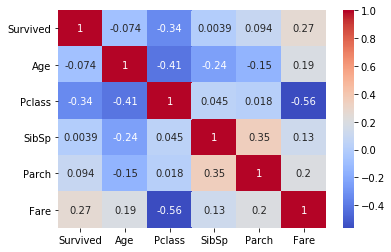

In [10]:
sns.heatmap(df[["Survived","Age","Pclass", "SibSp", "Parch", "Fare"]].corr(), cmap = 'coolwarm', annot = True)

Observations: 
* Fare has a significant effect on the Survival rate, Age has a negative impact whereas Parch and Sibsp have a small impact

Assumptions:
* High Fare payers may get preference due to t

## Comparing the effect of different features on the survival

In [11]:
#My function function to visualize and count the values in each category of each feature
def bar_plot(variable):
    
    #This code is used to solve problem when there are no survivors for a category, which causes an error in the display code
    feature_categories = df[variable].sort_values().unique()
    for category in feature_categories:
        temp_series = df["Survived"][df[variable] == category].value_counts(normalize = True)
        if temp_series.shape == (1,):
            temp_series = temp_series.append(pd.Series([0], index=[1]))
        elif temp_series.shape == (0,):
            continue
        print("Fraction of {} = {} who survived:".format(variable, category), temp_series[1])
    #visualize
    sns.barplot(x = df[variable],y = df["Survived"],  data = df).set_title('Fraction Survived With Respect To {}'.format(variable))

## 4.2 - PClass

Fraction of Pclass = 1 who survived: 0.6320754716981132
Fraction of Pclass = 2 who survived: 0.47282608695652173
Fraction of Pclass = 3 who survived: 0.24586776859504134


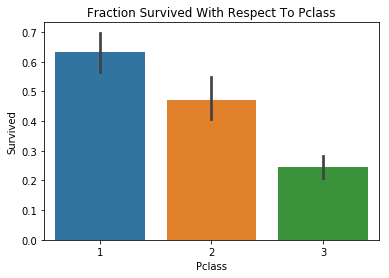

In [12]:
bar_plot("Pclass")

Observations:
* of all the Pclass 1 passengers, more than 60% survived
* of all the Pclass 2 passengers, just over 47% survived
* of all the Pclass 3 passengers, only 24% survived
* This bar plot shows that higher economic status of the passengers will have a higher the survival rate

## 4.3 - Sex

Fraction of Sex = female who survived: 0.7475728155339806
Fraction of Sex = male who survived: 0.19089316987740806


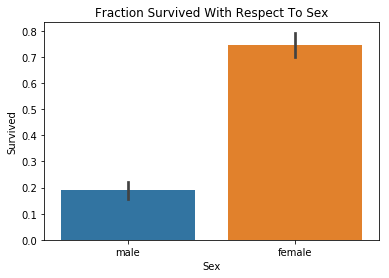

In [13]:
bar_plot("Sex")

Observations:
* of all the females, almost 75% survived
* of all the males, only about 19% survived
* This bar plot shows that females are more likely to survive than males 

## 4.4 - SibSp

Fraction of SibSp = 0 who survived: 0.34539473684210525
Fraction of SibSp = 1 who survived: 0.5384615384615384
Fraction of SibSp = 2 who survived: 0.4642857142857143
Fraction of SibSp = 3 who survived: 0.15384615384615385
Fraction of SibSp = 4 who survived: 0.16666666666666666
Fraction of SibSp = 5 who survived: 0.0


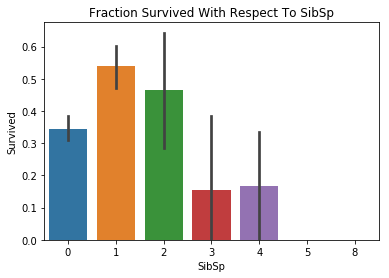

In [14]:
bar_plot("SibSp")

Observations:
* This feature had some unexpected results
* passengers no Siblings or Spouses had a lower survival rate (35%) than those with 1(56%) or 2(47%) Siblings/Spouses
* passengers with 3 or 4 Siblings/Spouses had a lower survival rate than passengers with 0 Siblings/Spouses
* There were no survivors of passengers with siblings more than 4

Assumption:
These observations can have meaning considering passenfers with too many Siblings/Spouses could have been killed in trying to save their large families, and passengers with zero Siblings/Spouses might not have been given preference.

## 4.5 - Parch

Fraction of Parch = 0 who survived: 0.34365781710914456
Fraction of Parch = 1 who survived: 0.5555555555555556
Fraction of Parch = 2 who survived: 0.5428571428571428
Fraction of Parch = 3 who survived: 0.6
Fraction of Parch = 4 who survived: 0.0
Fraction of Parch = 5 who survived: 0.2
Fraction of Parch = 6 who survived: 0.0


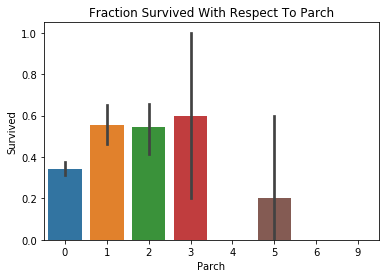

In [15]:
bar_plot("Parch")

Observations:
* People with smaller familes (1, 2, 3) had a better survival rate than people with larger familes
* Contrary to expectations, people with no family members had a lower survival rate than people with a few family members

## 4.6 - Embarked

Fraction of Embarked = C who survived: 0.5535714285714286
Fraction of Embarked = Q who survived: 0.38961038961038963
Fraction of Embarked = S who survived: 0.3417322834645669


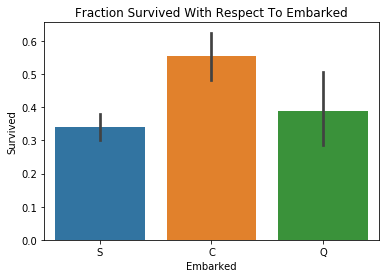

In [16]:
#Filling missing value
#Since Embarked only has 2 missing values, I will use the mode from the Series to determine the missing values
df["Embarked"] = df["Embarked"].fillna(df['Embarked'].mode()[0])
bar_plot("Embarked")

Observations:
* Passengers that embarked from Cherbourg(C), have the highest survival rate at almost 55%
* Passengers that embarked from Queenstown(Q), have a 40% survical rate
* Passengers that embarked from Southampton(S), have the lowest survival rate at just over 30%

Assumption: 
* People from Cherbourg may have gotten seat/cabins that are located on the top or closer to the top and they had easier access for escape or these passengers collectively had a higher economic status than the other places

Let's verify that assumption by correlating the Pclass with the Embarked

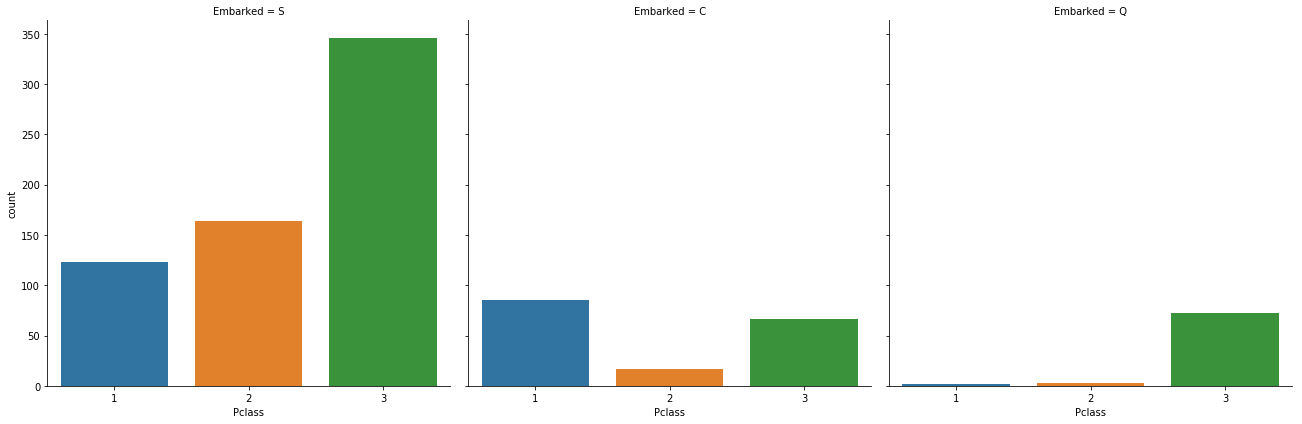

In [17]:
sns.factorplot("Pclass", col="Embarked",  data=train, size=6, kind="count")

This validates the assumption about embarked that we made earlier:
* Queenstown(Q) has almost exclusively Pclass = 3 passengers
* Southampton(S) has a majority of Pclass = 3 passengers
* Cherbourg(C) has a majority of Pclass = 1 passengers

Thus explaining why Cherbourg(C) has a higher survival rate than the other two embarked locations

## 4.7 - Cabin

It's highly like that recorded cabin values would mean a higher economic status and those who don't have a separate cabin belong to lower economic status.
Let's check the correlation of recorded cabin values with the Pclass to determine if there is any merit in our claim

recorded Cabins with pclass1 = 1: 252


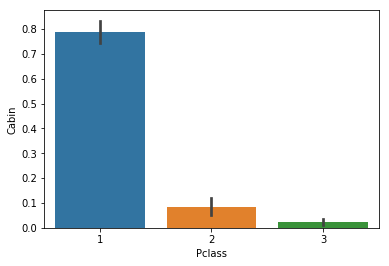

In [18]:
df["Cabin"] = df["Cabin"].notnull().astype(int)

pclass1 = df["Cabin"][df["Pclass"] == 1].value_counts()[1]
print("recorded Cabins with pclass1 = 1: {}".format(pclass1))

sns.barplot(x="Pclass", y="Cabin", data=df)

As it was assumed that most of the recorded cabins indeed belong to people with the highest economic status (80%) and thus cabin is directly correlated with the Pclass and having both Pclass and Cabin for out features in modeling will be redundant so we will remove the Cabin column when modeling.

# 5 - Removing missing values

## 5.1 - Age

Inspecting the correlations of various features on age to determine best technique to impute the missing Age data

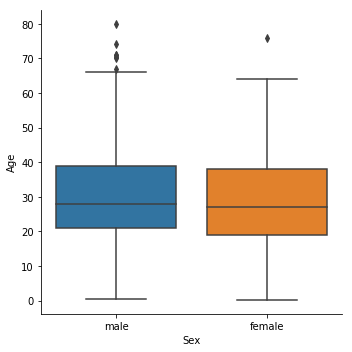

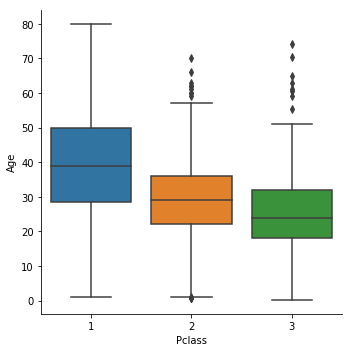

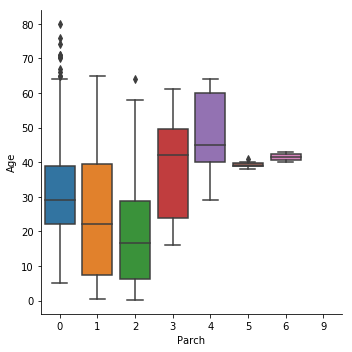

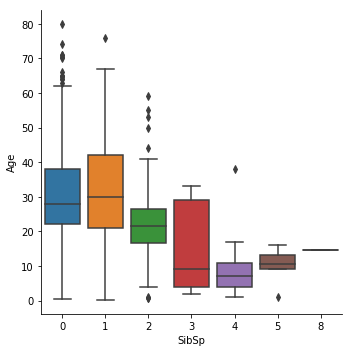

In [19]:
# Exploring Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=df, kind="box")
g = sns.factorplot(y="Age",x="Pclass", data=df, kind="box")
g = sns.factorplot(y="Age",x="Parch", data=df, kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=df, kind="box")


Observations:
* Gender has no effect on the Age feature thus it's safe to assume that to impute the Age column we don't have to consider the age
* In general, The higher the Pclass, the older the people
* Parch has a mixed correlation with Age so will need to keep this
* In general, The lesser the SibSp count, the older the age

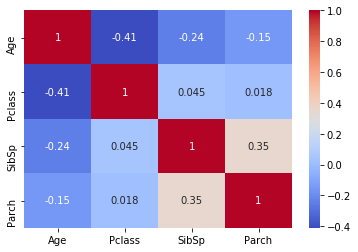

In [20]:
#Using a heatmap to determine the correlation between the remaining features
sns.heatmap(df[["Age","Pclass","SibSp", "Parch"]].corr(), cmap = 'coolwarm', annot = True)

In [21]:
#small function that will remove the missing values in the age column
def fill_age_missing_values(df):
    Age_Nan_Indices = list(df[df["Age"].isnull()].index)

    #for loop that iterates over all the missing age indices
    for index in Age_Nan_Indices:
        #temporary variables to hold SibSp, Parch and Pclass values pertaining to the current index
        temp_Pclass = df.iloc[index]["Pclass"]
        temp_SibSp = df.iloc[index]["SibSp"]
        temp_Parch = df.iloc[index]["Parch"]
        age_median = df["Age"][((df["Pclass"] == temp_Pclass) & (df["SibSp"] == temp_SibSp) & (df["Parch"] == temp_Parch))].median()
        if df.iloc[index]["Age"]:
            df["Age"].iloc[index] = age_median
        if np.isnan(age_median):
            df["Age"].iloc[index] = df["Age"].median()
    return df

In [22]:
#Using the function to remove missing values in both train and test set
df = fill_age_missing_values(df)
df.describe(include="all")

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1298.000000,1298.000000,1298,1297.000000,1298,1298.000000,1298.000000,1298.000000,1298,1298.000000,880.000000,1298
unique,NaN,NaN,3,NaN,1296,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,NaN,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA 2144
freq,NaN,NaN,905,NaN,2,NaN,NaN,NaN,837,NaN,NaN,8
mean,29.243968,0.224191,NaN,32.539427,NaN,0.372111,657.024653,2.295069,NaN,0.452234,0.386364,NaN
std,13.228053,0.417209,NaN,50.702961,NaN,0.857310,377.880768,0.836701,NaN,0.879624,0.487192,NaN
min,0.170000,0.000000,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,22.000000,0.000000,NaN,7.895800,NaN,0.000000,331.250000,2.000000,NaN,0.000000,0.000000,NaN
50%,26.000000,0.000000,NaN,14.454200,NaN,0.000000,656.500000,3.000000,NaN,0.000000,0.000000,NaN
75%,37.000000,0.000000,NaN,30.500000,NaN,0.000000,984.750000,3.000000,NaN,1.000000,1.000000,NaN


In [23]:
df["Age"].isnull().sum()

0

Comments:
* I decided to use the median technique rather than the mean technique to fill in the missing values to ensure I don't get values in decimal points
* I used a conditional statement where we check to determine the median age when all three conditions are satified, the conditions being
    * Same Pclass number
    * Same number of Siblings/Spouses (SibSp)   
    * Same number of Parents/Children (Parch)
    
As evident from the description of the dataframe above, we have removed all the NaN values in the Age column

# 6 - Feature Engineering

# 6.1 - Title feature

Getting the Title feature from the name

In [24]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,1,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,1,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


The "Title" can be extracted from the "Name" column by splitting the name and the title is between the comma and the period. ex. Braund, "Mr"(Title). Owen Harris

In [25]:
#Creating a new column("Title") using list comprehension
df["Title"] = pd.Series([name.split(",")[1].split(".")[0].strip() for name in df["Name"]])
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,1,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,1,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [26]:
pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,60
Miss,255,0


In [27]:
# Convert to categorical values Title 
df["Title"] = df["Title"].replace(['Lady', 'the Countess', 'Countess', 'Don', 'Jonkheer', 'Dona', 'Sir'], 'Royals')
df["Title"] = df["Title"].replace(['Col', 'Dr', 'Major', 'Capt'], 'Professionals')
df["Title"] = df["Title"].replace(["Ms", "Mme", "Mlle", "Mrs"], 'Miss')
df["Title"] = df["Title"].replace(['Master', 'Rev'], 'Mas/Rev')
df["Title"] = df["Title"].map({"Mas/Rev": 0, "Miss": 1, "Mr": 2, "Royals": 3, "Professionals": 4})

In [28]:
pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
0,0,68
1,457,0
2,0,753
3,3,3
4,1,13


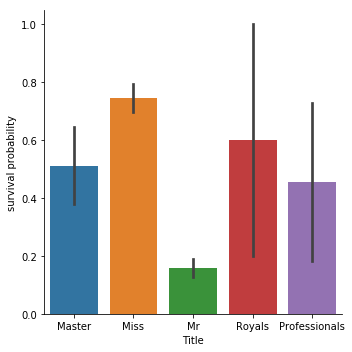

In [29]:
sns.factorplot(x="Title",y="Survived",data=df, kind="bar").set_xticklabels(["Master","Miss","Mr","Royals","Professionals"]).set_ylabels("survival probability")

## 6.2 - Family Total

Let's convert the Parch and SibSp into a single feature known as Ftotal

In [30]:
df["Ftotal"] = 1 + df["SibSp"] + df["Parch"]

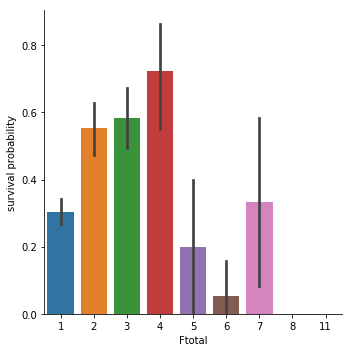

In [31]:
sns.factorplot(x="Ftotal",y="Survived",data=df, kind="bar").set_ylabels("survival probability")

Now we can drop the seperate SibSp and Parch columns

## 6.3 - Grouping age groups

Since we have a very big variation in age, we can engineerinf the age feature into age groups

In [32]:
df["Age"] = df["Age"].astype(int)
df.loc[(df['Age'] <= 2), 'Age Group'] = 'Baby' 
df.loc[((df["Age"] > 2) & (df['Age'] <= 10)), 'Age Group'] = 'Child' 
df.loc[((df["Age"] > 10) & (df['Age'] <= 19)), 'Age Group'] = 'Young Adult'
df.loc[((df["Age"] > 19) & (df['Age'] <= 60)), 'Age Group'] = 'Adult'
df.loc[(df["Age"] > 60), 'Age Group'] = 'Senior'
df["Age Group"] = df["Age Group"].map({"Baby": 0, "Child": 1, "Young Adult": 2, "Adult": 3, "Senior": 4})

In [33]:
df.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Ftotal,Age Group
293,39,1,S,30.5000,"Saalfeld, Mr. Adolphe",0,299,1,male,0,1.0,19988,2,1,3
1122,45,1,C,134.5000,"Spedden, Mr. Frederic Oakley",1,1134,1,male,1,NaN,16966,2,3,3
1239,30,0,S,15.5500,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",0,1251,3,female,1,NaN,349910,1,2,3
994,63,1,S,221.7792,"Straus, Mrs. Isidor (Rosalie Ida Blun)",0,1006,1,female,1,NaN,PC 17483,1,2,4
1137,28,0,S,8.0500,"Niklasson, Mr. Samuel",0,1149,3,male,0,NaN,363611,2,1,3


In [34]:
df.describe(include = "all")

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Ftotal,Age Group
count,1298.000000,1298.000000,1298,1297.000000,1298,1298.000000,1298.000000,1298.000000,1298,1298.000000,880.000000,1298,1298.000000,1298.000000,1298.000000
unique,NaN,NaN,3,NaN,1296,NaN,NaN,NaN,2,NaN,NaN,929,NaN,NaN,NaN
top,NaN,NaN,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA 2144,NaN,NaN,NaN
freq,NaN,NaN,905,NaN,2,NaN,NaN,NaN,837,NaN,NaN,8,NaN,NaN,NaN
mean,29.222650,0.224191,NaN,32.539427,NaN,0.372111,657.024653,2.295069,NaN,0.452234,0.386364,NaN,1.569337,1.824345,2.744992
std,13.241038,0.417209,NaN,50.702961,NaN,0.857310,377.880768,0.836701,NaN,0.879624,0.487192,NaN,0.651349,1.427225,0.693950
min,0.000000,0.000000,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,0.000000,1.000000,0.000000
25%,22.000000,0.000000,NaN,7.895800,NaN,0.000000,331.250000,2.000000,NaN,0.000000,0.000000,NaN,1.000000,1.000000,3.000000
50%,26.000000,0.000000,NaN,14.454200,NaN,0.000000,656.500000,3.000000,NaN,0.000000,0.000000,NaN,2.000000,1.000000,3.000000
75%,37.000000,0.000000,NaN,30.500000,NaN,0.000000,984.750000,3.000000,NaN,1.000000,1.000000,NaN,2.000000,2.000000,3.000000


## 6.4 - Solving fare skewness

I used help from [here](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/) on how to tackle the fare column as fare values were highly skewed towards the low end.

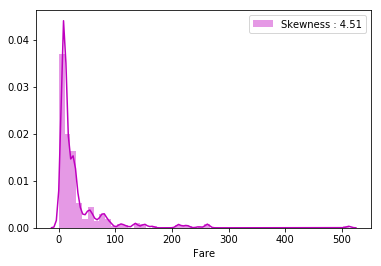

In [35]:
sns.distplot(df["Fare"], color="m", label="Skewness : %.2f"%(df["Fare"].skew())).legend(loc="best")

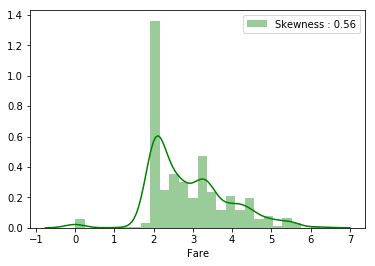

In [36]:
# Apply log to Fare to reduce skewness distribution
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
sns.distplot(df["Fare"], color="g", label="Skewness : %.2f"%(df["Fare"].skew())).legend(loc="best")

Now the fare is much less skewed as skewness went from 4.51 to 0.56

## 6.5 - Mapping categorical sex feature

In [37]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Ftotal,Age Group
935,10,0,Q,3.371597,"Rice, Master. Albert",1,947,3,0,4,NaN,382652,0,6,1
98,28,0,S,2.066331,"Petranec, Miss. Matilda",0,101,3,1,0,0.0,349245,1,1,3
438,4,1,S,4.404990,"Dodge, Master. Washington",2,446,1,0,0,1.0,33638,0,3,1
390,46,0,S,3.258097,"McKane, Mr. Peter David",0,398,2,0,0,0.0,28403,2,1,3
553,25,0,Q,2.047693,"Morrow, Mr. Thomas Rowan",0,561,3,0,0,0.0,372622,2,1,3


## 6.6 - Mapping categorical embarked feature

In [38]:
df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})
df.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Ftotal,Age Group
207,22,0,2,1.981001,"Perkin, Mr. John Henry",0,213,3,0,0,0.0,A/5 21174,2,1,3
673,25,0,1,2.096483,"Peters, Miss. Katie",0,681,3,1,0,0.0,330935,1,1,3
489,54,1,0,4.360122,"Eustis, Miss. Elizabeth Mussey",0,497,1,1,1,1.0,36947,1,2,3
633,20,0,2,2.061048,"Jensen, Mr. Hans Peder",0,641,3,0,0,0.0,350050,2,1,3
623,80,1,2,3.401197,"Barkworth, Mr. Algernon Henry Wilson",0,631,1,0,0,1.0,27042,2,1,4


## 6.7 - Removing non-essential features

Some of these features now are reduntant as we have used feature engineering to extract the important details, such features are:
* Name, after we extracted the Title feature, it is not useful anymore
* Parch and SibSp feature as we have combined the 2 into a single feature called Ftotal
* Ticket  and PassnegerID features as they gives nothing significant for the determination
* Age as we made age groups instead

In [39]:
passenger_ID = pd.Series(df["PassengerId"], name = "PassengerId")
df = df.drop(["Name", "PassengerId", "SibSp", "Parch", "Age", "Ticket"], axis=1)
df.sample(5)

,Cabin,Embarked,Fare,Pclass,Sex,Survived,Title,Ftotal,Age Group
443,0,2,3.323236,2,0,0.0,2,4,3
59,0,0,1.978128,3,0,0.0,2,1,3
167,1,2,3.511545,1,0,0.0,2,1,4
239,0,0,1.977547,3,0,0.0,2,1,3
540,0,0,2.629187,2,0,1.0,2,1,3


## 6.8 - Get categorical dummies

For some features we have categories and these categories require dummies variables

In [40]:
df = pd.get_dummies(df, columns = ["Title"])
df = pd.get_dummies(df, columns = ["Embarked"])
df = pd.get_dummies(df, columns = ["Pclass"])
df = pd.get_dummies(df, columns = ["Age Group"])

# 7 - Building/Training our model

## 7.1 - Seperating Train/Test dataset

In [41]:
train = df[:train.shape[0]]
test = df[train.shape[0]:].drop(["Survived"], axis = 1)

## 7.2 -  Modelling various classifiers

In [42]:
#StratifiedKFold aims to ensure each class is (approximately) equally represented across each test fold
k_fold = StratifiedKFold(n_splits=5)

X_train = train.drop(labels="Survived", axis=1)
y_train = train["Survived"]

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# Creating objects of each classifier
LG_classifier = LogisticRegression(random_state=0)
SVC_classifier = SVC(kernel="rbf", random_state=0)
KNN_classifier = KNeighborsClassifier()
NB_classifier = GaussianNB()
DT_classifier = DecisionTreeClassifier(criterion="entropy", random_state=0)
RF_classifier = RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=0)

#putting the classifiers in a list so I can iterate over there results easily
titanic_classifiers = [LG_classifier, SVC_classifier, KNN_classifier, NB_classifier, DT_classifier, RF_classifier]

#This dictionary is just to grad the name of each classifier
classifier_dict = {
    0: "Logistic Regression",
    1: "Support Vector Classfication",
    2: "K Nearest Neighbor Classification",
    3: "Naive bayes Classifier",
    4: "Decision Trees Classifier",
    5: "Random Forest Classifier",
}

titanic_results = pd.DataFrame({'Model': [],'Mean Accuracy': [], "Standard Deviation": []})

#Iterating over each classifier and getting the result
for i, classifier in enumerate(titanic_classifiers):
    classifier_scores = cross_val_score(classifier, X_train, y_train, cv=k_fold, n_jobs=2, scoring="accuracy")
    titanic_results = titanic_results.append(pd.DataFrame({"Model":[classifier_dict[i]], 
                                                           "Mean Accuracy": [classifier_scores.mean()],
                                                           "Standard Deviation": [classifier_scores.std()]}))

In [43]:
print (titanic_results.to_string(index=False))

                             Model  Mean Accuracy  Standard Deviation
               Logistic Regression       0.812500            0.016071
      Support Vector Classfication       0.815909            0.016310
 K Nearest Neighbor Classification       0.795455            0.019682
            Naive bayes Classifier       0.764773            0.020830
         Decision Trees Classifier       0.814773            0.030407
          Random Forest Classifier       0.817045            0.035646


Observations:
* K nearest neighbors and Naive bayes have accuracies below 80% and thus I will not consider them anymore.
* Even though Logistic regression does a job aswell as the other classifiers, it's accuracy was the lowest among the remaining 5, so I will not use this classifier further
* Random Forest classifier gives the best results among all classifiers so I will use this classifier as the final classifier for my submission but not before tuning hyper parameters using GridSearchSV

## 7.3 - Hyperparameter Tuning

In [44]:
from sklearn.model_selection import GridSearchCV

RF_classifier = RandomForestClassifier()


## Search grid for optimal parameters
RF_paramgrid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,200,300],
                  "criterion": ["entropy"]}


RF_classifiergrid = GridSearchCV(RF_classifier, param_grid = RF_paramgrid, cv=k_fold, scoring="accuracy", n_jobs= -1, verbose=1)

RF_classifiergrid.fit(X_train,y_train)

RFC_optimum = RF_classifiergrid.best_estimator_

# Best Accuracy Score
RF_classifiergrid.best_score_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.2min finished


0.8340909090909092

In [45]:
IDtest = passenger_ID[train.shape[0]:].reset_index(drop = True)

## 7.4 - Submitting

In [46]:
from sklearn.ensemble import RandomForestClassifier
X_train = train.drop(labels="Survived", axis=1)
y_train = train["Survived"]

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(test)

RFC_optimum.fit(X_train, y_train)

test_predictions = pd.Series(RFC_optimum.predict(X_test).astype(int), name="Survived")
titanic_results = pd.concat([IDtest, test_predictions], axis = 1)
titanic_results.to_csv('submission.csv', index=False)

If you find this notebook helpful, please upvote and if you have any questions, feel free to ask in the comment section.
Have a great day :)